In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [4]:
!cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Download Dataset
!kaggle datasets download -d sainikhileshreddy/food-recognition-2022

100% 4.90G/4.91G [00:26<00:00, 266MB/s]
100% 4.91G/4.91G [00:26<00:00, 199MB/s]


In [6]:
!unzip -q /content/food-recognition-2022.zip -d /content/food-recognition-2022

In [7]:
import pandas as pd
import json

def create_dataframe(annotations_path):
    with open(annotations_path, 'r') as file:
        data = json.load(file)

    images = pd.DataFrame(data['images']).rename(columns={'id': 'image_id'})[['image_id', 'file_name']]

    categories = pd.DataFrame(data['categories'])[['id', 'name']]
    categories.rename(columns={'id': 'category_id'}, inplace=True)

    usecols = ['image_id', 'category_id']
    annotations = pd.DataFrame(data['annotations'])[usecols]

    dataframe = annotations.merge(categories, on='category_id').merge(images, on='image_id')[['file_name', 'name']]

    return dataframe

In [9]:
train_df = create_dataframe('/content/food-recognition-2022/raw_data/public_training_set_release_2.0/annotations.json')
train_df

,file_name,name
0,131094.jpg,soft-cheese
1,131094.jpg,ham-raw
2,131094.jpg,hard-cheese
3,131094.jpg,bread-wholemeal
4,131094.jpg,cottage-cheese
...,...,...
76486,117029.jpg,damson-plum
76487,117524.jpg,damson-plum
76488,117849.jpg,damson-plum
76489,123468.jpg,damson-plum


In [10]:
import os

splits = ['train', 'validation']

for split in splits:
    root = f'/content/dataset/{split}'

    for index, row in train_df.iterrows():
        directory_name = row['name']
        directory_path = os.path.join(root, directory_name)

        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

In [12]:
validation_df = create_dataframe('/content/food-recognition-2022/raw_data/public_validation_set_2.0/annotations.json')
validation_df

,file_name,name
0,149022.jpg,espresso-with-caffeine
1,149022.jpg,dark-chocolate
2,167905.jpg,espresso-with-caffeine
3,121313.jpg,espresso-with-caffeine
4,153429.jpg,espresso-with-caffeine
...,...,...
1825,144675.jpg,oat-milk
1826,103273.jpg,soup-potato
1827,159922.jpg,red-cabbage
1828,011275.jpg,pasta-in-conch-form


In [13]:
import os
import shutil

def copy_images_to_destination(base_dir, dataframe, split):
    images_dir = os.path.join(base_dir, 'images')

    for index, row in dataframe.iterrows():
        file_name = row['file_name']
        file_class = row['name']

        dest_dir = os.path.join('/content', 'dataset', split, file_class)
        os.makedirs(dest_dir, exist_ok=True)

        source_path = os.path.join(images_dir, file_name)
        destination_path = os.path.join(dest_dir, file_name)

        shutil.copyfile(source_path, destination_path)

    print("Done copying images.")

In [14]:
# copying training images to their respective classes

base_dir = '/content/food-recognition-2022/raw_data/public_training_set_release_2.0'
dataframe = train_df
copy_images_to_destination(base_dir, dataframe, 'train')

Done copying images.


In [17]:
# copying validation images to their respective classes

base_dir = '/content/food-recognition-2022/raw_data/public_validation_set_2.0'
dataframe = validation_df
copy_images_to_destination(base_dir, dataframe, 'validation')

Done copying images.


In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

Sample apple image:


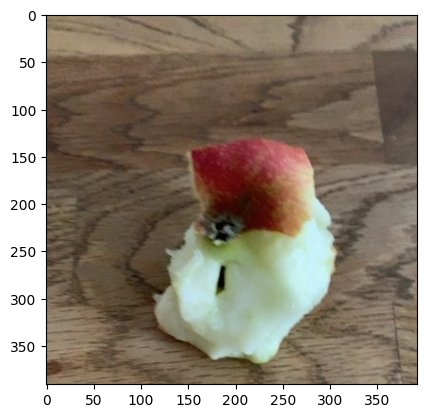


Sample apple-pie image:


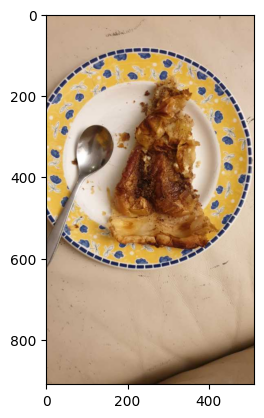

In [20]:
from tensorflow.keras.preprocessing.image import load_img

base_dir = "/content/dataset/train"
apple_dir = os.path.join(base_dir, "apple/")
apple_pie_dir = os.path.join(base_dir, "apple-pie/")

print("Sample apple image:")
plt.imshow(load_img(f"{os.path.join(apple_dir, os.listdir(apple_dir)[0])}"))
plt.show()

print("\nSample apple-pie image:")
plt.imshow(load_img(f"{os.path.join(apple_pie_dir, os.listdir(apple_pie_dir)[0])}"))
plt.show()


In [22]:
from tensorflow.keras.preprocessing.image import img_to_array

# Load the first example of a happy face
sample_image  = load_img(f"{os.path.join(apple_dir, os.listdir(apple_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")



Each image has shape: (853, 853, 3)
The maximum pixel value used is: 255.0


In [23]:
from tensorflow.keras.preprocessing.image import img_to_array

# Load the first example of a happy face
sample_image  = load_img('/content/dataset/train/bacon-raw/014847.jpg')

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")



Each image has shape: (853, 853, 3)
The maximum pixel value used is: 255.0


In [24]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.81:
            print("\nReached 81% accuracy so cancelling training!")
            self.model.stop_training = True

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def image_generator():
    train_datagen = ImageDataGenerator(rescale=1./255)

    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    train_generator = train_datagen.flow_from_directory(directory=base_dir,
                                                        target_size=(300, 300),
                                                        batch_size=128,
                                                        class_mode='categorical')

    return train_generator


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/dataset/validation',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        class_mode='categorical')


Found 1799 images belonging to 498 classes.


In [30]:
# Save generator in a variable
gen = image_generator()

Found 70397 images belonging to 498 classes.


In [34]:
from tensorflow.keras import optimizers, losses, layers

# Instantiate the callback
callbacks = myCallback()

# Define the model
model = tf.keras.models.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    layers.MaxPooling2D(2, 2),
    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # Flatten the output for the fully connected layers
    layers.Flatten(),
    # Fully Connected Layer 1
    layers.Dense(128, activation='relu'),
    # Output Layer
    layers.Dense(498, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


# Train the model
history = model.fit(
      gen,
      steps_per_epoch
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      callbacks = [callbacks])

Epoch 1/15
340/550 [=================>............] - ETA: 3:19 - loss: 5.4484 - accuracy: 0.0634

KeyboardInterrupt: 

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential()

# Input layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add more convolutional layers with pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from convolutional layers
model.add(Flatten())

# Add fully connected (dense) layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(498, activation='softmax'))  # Output layer with 498 classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary to view the architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 35, 35, 128)      

In [37]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


# Train the model
history = model.fit(
      gen,
      epochs=15,
      steps_per_epoch=100,
      verbose=1,
      validation_data = validation_generator,
      callbacks = [callbacks])

Epoch 1/15
100/100 [==============================] - 103s 988ms/step - loss: 5.8734 - accuracy: 0.0423 - val_loss: 5.5363 - val_accuracy: 0.0584
Epoch 2/15
100/100 [==============================] - 108s 1s/step - loss: 5.4329 - accuracy: 0.0663 - val_loss: 5.4238 - val_accuracy: 0.0778
Epoch 3/15
100/100 [==============================] - 101s 1s/step - loss: 5.3076 - accuracy: 0.0791 - val_loss: 5.3481 - val_accuracy: 0.0773
Epoch 4/15
100/100 [==============================] - 107s 1s/step - loss: 5.2232 - accuracy: 0.0793 - val_loss: 5.2802 - val_accuracy: 0.0867
Epoch 5/15
100/100 [==============================] - 98s 979ms/step - loss: 5.1673 - accuracy: 0.0920 - val_loss: 5.2241 - val_accuracy: 0.0895
Epoch 6/15
100/100 [==============================] - 103s 1s/step - loss: 5.1198 - accuracy: 0.0927 - val_loss: 5.1733 - val_accuracy: 0.0956
Epoch 7/15
100/100 [==============================] - 96s 954ms/step - loss: 5.0627 - accuracy: 0.0973 - val_loss: 5.1217 - val_accuracy:

In [38]:
print(f"Your model reached the desired accuracy after {len(history.epoch)} epochs")

Your model reached the desired accuracy after 15 epochs


In [39]:
train_generator.class_indices

NameError: name 'train_generator' is not defined

In [40]:
class_names = gen.class_indices
class_names

{'alfa-sprouts': 0,
 'almonds': 1,
 'anchovies': 2,
 'aperitif-with-alcohol-aperol-spritz': 3,
 'apple': 4,
 'apple-crumble': 5,
 'apple-pie': 6,
 'applesauce-unsweetened-canned': 7,
 'apricot-dried': 8,
 'apricots': 9,
 'artichoke': 10,
 'avocado': 11,
 'bacon': 12,
 'bacon-cooking': 13,
 'bacon-frying': 14,
 'bacon-raw': 15,
 'bagel-without-filling': 16,
 'baked-potato': 17,
 'balsamic-salad-dressing': 18,
 'balsamic-vinegar': 19,
 'banana': 20,
 'banana-cake': 21,
 'basil': 22,
 'bean-seeds': 23,
 'beans-kidney': 24,
 'beans-white': 25,
 'beef': 26,
 'beef-cut-into-stripes-only-meat': 27,
 'beef-filet': 28,
 'beef-minced-only-meat': 29,
 'beef-roast': 30,
 'beef-sirloin-steak': 31,
 'beer': 32,
 'beetroot-raw': 33,
 'beetroot-steamed-without-addition-of-salt': 34,
 'bell-pepper-red-raw': 35,
 'bell-pepper-red-stewed-without-addition-of-fat-without-addition-of-salt': 36,
 'berries': 37,
 'birchermuesli-prepared-no-sugar-added': 38,
 'biscuit-with-butter': 39,
 'biscuits': 40,
 'black

Saving 007928.jpg to 007928 (1).jpg
1/1 [==============================] - 1s 731ms/step
Predicted class: salad-leaf-salad-green
Class probabilities: [[3.00188549e-03 9.81923076e-04 7.32537941e-04 6.55878903e-05
  8.22130591e-03 7.44336721e-05 3.08714836e-04 5.54004335e-04
  1.77602546e-04 2.37727974e-04 1.54814520e-03 2.98020821e-02
  8.18310946e-04 2.63772137e-03 2.70755612e-03 4.17614123e-04
  1.42462755e-04 3.01724346e-03 9.67011973e-03 1.13053713e-03
  2.78854603e-03 3.98727745e-04 1.84025965e-03 4.03312384e-04
  2.29816232e-03 4.47712926e-04 1.74464111e-03 6.69765694e-04
  1.46113965e-03 1.78263918e-03 5.39069471e-04 1.13820599e-03
  3.55685101e-04 2.18306435e-03 4.78237588e-03 8.93039163e-03
  4.51885426e-04 8.18124914e-04 1.14299206e-03 6.60056685e-05
  4.63486271e-04 1.84448698e-04 6.34556543e-03 1.08443288e-04
  1.01957307e-03 1.69599417e-03 7.55930727e-04 4.26660932e-04
  2.77749845e-04 1.24470482e-03 1.73713733e-03 9.32443436e-05
  2.24459195e-03 3.95834853e-04 1.05812505e-

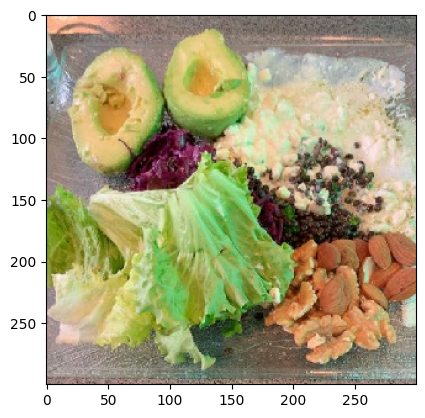

In [42]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  predictions = model.predict(images, batch_size=10)

  # Get the predicted class index
  predicted_class_index = np.argmax(predictions)

  # Get the predicted class label from the 'gen' variable
  predicted_class = list(class_names.keys())[list(class_names.values()).index(predicted_class_index)]

  # Print the prediction
  print("Predicted class:", predicted_class)
  # print("Class probabilities:", predictions)

  plt.imshow(img)
  plt.show()